### Finetuning Gemma Model 3 for a Image Vision Tasks
In this notebook we demonstrate how to build a Finetune model using NVIDIA A100 GPUs. We will use the GPU during inference. The approach will be based on [Parameter Efficient Fine Tuning (peft)](https://github.com/huggingface/peft).

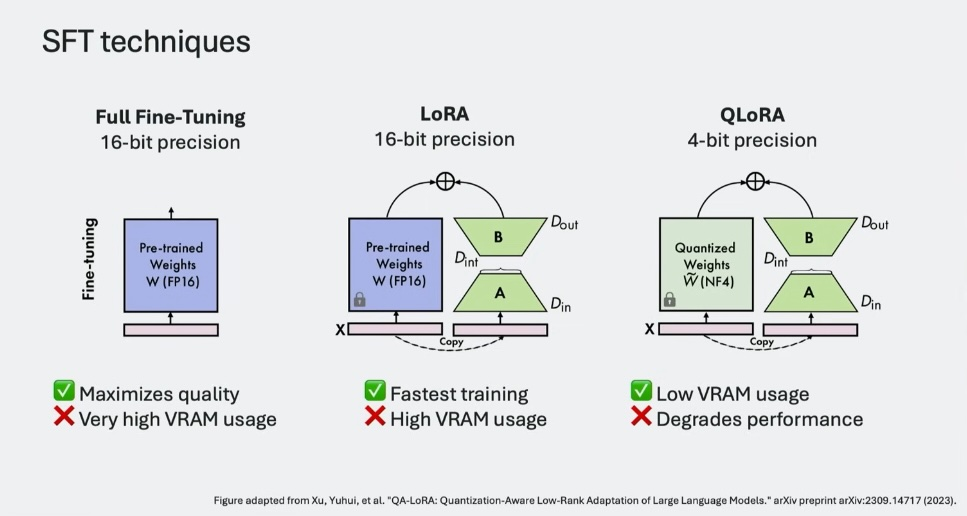

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; Setup <code>install the first set of libraries</code>. <b>To Access Gemma Model on Hugging Face files</b>: 1) click on the Hugging Face and create an account and then 2) click on "Profile" then follow the steps to generate an API key 3) <code> pip install -U "huggingface_hub[cli]"</code> and Set the Token.</p>



<p> ⬇ &nbsp; <b>Training:</b> 1) Step <em>"4-10"</em> are the training steps which should only be performed once then 2) Run <em>Steps 2,3,4(library & configs)</em> except <em> before doing your inference if you restart the kernel</em>.</p>

<p> 📒 &nbsp; Production, You can host the model on GPU powered Serverless Compute <em>"or publicly on hugging face"</em>.</p>
</div>

In [1]:
# Repeat Steps 2,3,4(library & configs) if you restart your notebook after training & model is merging

In [2]:
# Verify you have the right python version (3.11)running - Uncomment to run
# !python -V
#If you are not running Python3.11 you can activate with Conda - https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-python.html
# conda env list
# conda create -n python311 python=3.11
# conda activate python311

In [3]:
# Step 1 - Install all the libraries - Uncomment to run
# !pip install datasets
# !pip uninstall torch torchvision torchaudio --y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # or your specific CUDA version
# !pip uninstall flash-attn --y
# !pip install transformers
# !pip install bitsandbytes
# !pip install accelerate
# !pip install peft
# !pip install trl

In [4]:
# setup env [Optional] - Don't run this except the previous steps is giving an issue
# Install Pytorch & other libraries
# %pip install "torch>=2.4.0" tensorboard torchvision

# # Install Gemma release branch from Hugging Face
# %pip install "transformers>=4.51.3"

# # Install Hugging Face libraries
# %pip install  --upgrade \
#   "datasets==3.3.2" \
#   "accelerate==1.4.0" \
#   "evaluate==0.4.3" \
#   "bitsandbytes==0.45.3" \
#   "trl==0.15.2" \
#   "peft==0.14.0" \
#   "pillow==11.1.0" \
#   protobuf \
#   sentencepiece

In [5]:
# Step 2 - Load the Python Libraries
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
# load the datasets
from datasets import load_dataset
from PIL import Image

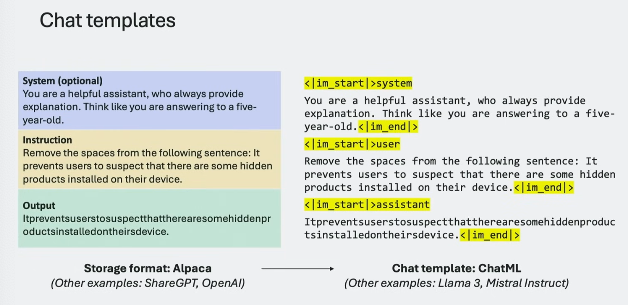

In [43]:
# Step 3 - Prepare the data - You need to repeat this format again for inference 
# We will prepare our dataset using Open AI format -> System Message, User Prompt - https://platform.openai.com/docs/guides/text?api-mode=chat
# Sample Data
# ------------
{"messages": [{"role": "system", "content": [{"type": "text", "text":"You are..."}]}, {"role": "user", "content": [{"type": "text", "text": "..."}, {"type": "image"}]}, {"role": "assistant", "content": [{"type": "text", "text": "..."}]}]}
{"messages": [{"role": "system", "content": [{"type": "text", "text":"You are..."}]}, {"role": "user", "content": [{"type": "text", "text": "..."}, {"type": "image"}]}, {"role": "assistant", "content": [{"type": "text", "text": "..."}]}]}
{"messages": [{"role": "system", "content": [{"type": "text", "text":"You are..."}]}, {"role": "user", "content": [{"type": "text", "text": "..."}, {"type": "image"}]}, {"role": "assistant", "content": [{"type": "text", "text": "..."}]}]}
# ---------
# System message for the assistant
system_message = "You are an expert product description writer for Amazon."

# User prompt that combines the user query and the schema
user_prompt = """Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.
<PRODUCT>
{product}
</PRODUCT>

<CATEGORY>
{category}
</CATEGORY>
"""

In [7]:
# Convert dataset to OAI messages format
def format_data(sample):
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt.format(
                            product=sample["Product Name"],
                            category=sample["Category"],
                        ),
                    },
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["description"]}],
            },
        ],
    }

#Converts the Image to RGB format
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

In [8]:
# Step 4: Load the gemma 3 model, you will accept the terms on Hugging Face
# A100 or H100 GPU 80GB RAM with 300GB space with support bfloat16

# Hugging Face model id
model_id = "google/gemma-3-4b-pt" # or `google/gemma-3-12b-pt`, `google/gemma-3-27-pt`

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch.bfloat16, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

# BitsAndBytesConfig int-4 config
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

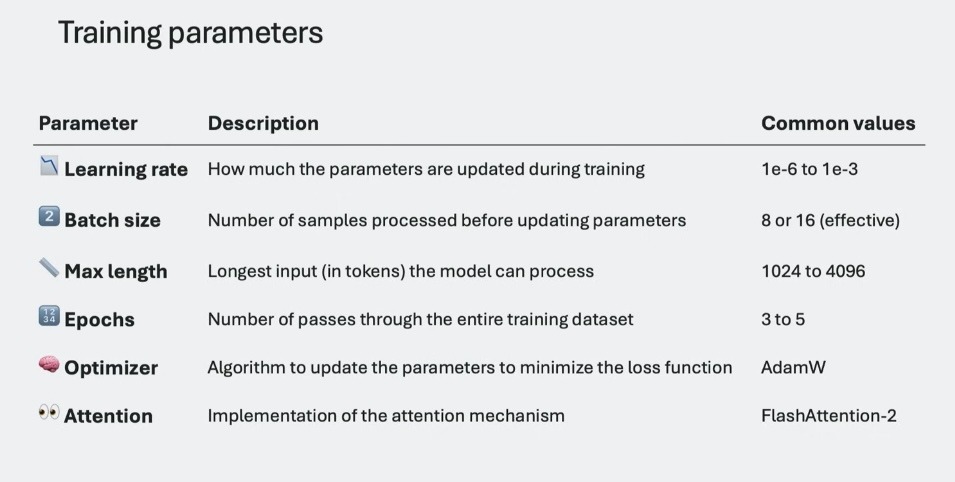

In [9]:
# define hyperparams - You may need to repeat during Inference
from trl import SFTConfig

args = SFTConfig(
    output_dir="gemma-product-description",     # directory to save and repository id
    num_train_epochs=1,                         # number of training epochs
    per_device_train_batch_size=1,              # batch size per device during training
    gradient_accumulation_steps=4,              # number of steps before performing a backward/update pass
    gradient_checkpointing=True,                # use gradient checkpointing to save memory
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    logging_steps=5,                            # log every 5 steps
    save_strategy="epoch",                      # save checkpoint every epoch
    learning_rate=2e-4,                         # learning rate, based on QLoRA paper
    bf16=True,                                  # use bfloat16 precision
    max_grad_norm=0.3,                          # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                          # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",               # use constant learning rate scheduler
    push_to_hub=True,                           # push model to hub
    report_to="tensorboard",                    # report metrics to tensorboard
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },  # use reentrant checkpointing
    dataset_text_field="",                      # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True},  # important for collator
)
args.remove_unused_columns = False # important for collator

In [7]:
# Step 5: Load dataset from the hugging face hub
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm", split="train")

# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .map convert image to bytes
dataset = [format_data(sample) for sample in dataset]

print(dataset[345]["messages"])

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert product description writer for Amazon.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n<PRODUCT>\nMasterPieces Tribal Spirit Jigsaw Puzzle, The Chiefs, Featuring American Indian Tribe Traditions & Ceremonies, 1000 Pieces\n</PRODUCT>\n\n<CATEGORY>\nToys & Games | Puzzles | Jigsaw Puzzles\n</CATEGORY>\n'}, {'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FE8E80C9DE0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Challenge yourself with this 1000-piece MasterPieces Tribal Spirit jigsaw puzzle!  Depicting the rich traditions and ceremonies of American Indian tribes, "The Chiefs" offers a stunning, culturally significant image perfect for pu

In [ ]:
#Step 6: Load model and tokenizer
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

In [6]:
#Step 7: Load the peft configs
#The SFTTrainer supports a built-in integration with peft, 
# which makes it straightforward to efficiently tune LLMs using QLoRA. You only need to create a LoraConfig and provide it to the trainer.
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [6]:
#Step 8: # Create a data collator to encode text and image pairs
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [8]:
# Create the SFTtrainer
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Model Training)</code>:</b> This notebook takes about two hours to be ready to use. You may start and do something else while you wait.</p>

In [ ]:
# Step 9: finetune using Gemma TRL and SFTtrainer - You only need to do this once
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
5,9.893400
10,5.742300
15,5.039500
20,4.468200
25,3.765200
30,3.847300
35,3.567300
40,3.645300
45,3.726200
50,3.424300


No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
# free some memory
del model
del trainer
torch.cuda.empty_cache()

In [ ]:
#Step 10: merge the model

# When using QLoRA, you only train adapters and not the full model. This means when saving the model during training you only 
# save the adapter weights and not the full model. If you want to save the full model, which makes it easier to use with serving stacks 
# like vLLM or TGI, you can merge the adapter weights into the model weights using the merge_and_unload method
# and then save the model with the save_pretrained method. This saves a default model, which can be used for inference.
from peft import PeftModel

# Load Model base model
model = AutoModelForImageTextToText.from_pretrained(model_id, low_cpu_mem_usage=True)

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, args.output_dir)
merged_model = peft_model.merge_and_unload()
merged_model.save_pretrained("merged_model", safe_serialization=True, max_shard_size="2GB")

processor = AutoProcessor.from_pretrained(args.output_dir)
processor.save_pretrained("merged_model")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['merged_model/processor_config.json']

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

In [10]:
#Test Model Inference and generate product descriptions
import torch

# Load Model with PEFT adapter
model = AutoModelForImageTextToText.from_pretrained(
  args.output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU else eager
)
processor = AutoProcessor.from_pretrained(args.output_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
# You can test inference by providing a product name, category and image. The sample includes a marvel action figure.
import requests
from PIL import Image

# Test sample with Product Name, Category and Image
sample = {
  "product_name": "Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur",
  "category": "Toys & Games | Toy Figures & Playsets | Action Figures",
  "image": Image.open(requests.get("https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg", stream=True).raw).convert("RGB")
}

def generate_description(sample, model, processor):
    # Convert sample into messages and then apply the chat template
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": user_prompt.format(product=sample["product_name"], category=sample["category"])},
        ]},
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)

    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
description = generate_description(sample, model, processor)
print(description)

Bring home the electrifying action of Marvel's Iron Man! This 30.5cm Titan-Headed action figure from the Marvel Assemble series is a must-have for Marvel fans and collectors.  Highly detailed and expertly crafted, it's perfect for recreating epic battles or displaying proudly. Add this iconic Marvel hero to your collection today!


##### Credits: Some of the materials were take from the [Google Cloud Blog](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora)

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their probabilistic nature. Don't be surprised if your results differ from those shown.</p>

In [23]:
# https://www.amazon.com/Black-Panther-Battle-Wakanda-Chapter/dp/1368020143/
#Black Panther
product_name = input("What is your product name? ")
print(f"Product Name -> {product_name}!")

What is your product name?  Black Panther


Product Name -> Black Panther!


In [27]:
# https://m.media-amazon.com/images/I/8195JkJhv-L._SY342_.jpg
# https://m.media-amazon.com/images/I/8195JkJhv-L._SY425_.jpg
product_image_url = input("What is your product image url? ")
print(f"Product Image Link -> {product_image_url}!")

What is your product image url?  https://m.media-amazon.com/images/I/8195JkJhv-L._SY425_.jpg


Product Image Link -> https://m.media-amazon.com/images/I/8195JkJhv-L._SY425_.jpg!


In [18]:
# Define product categories
CATEGORIES = [
    "Electronics | Computers & Accessories | Laptops",
    "Electronics | Cell Phones & Accessories | Cases",
    "Electronics | Camera & Photo | Digital Cameras",
    "Electronics | TV & Video | Televisions",
    "Electronics | Audio & Home Theater | Headphones",
    "Home & Kitchen | Kitchen & Dining | Small Appliances",
    "Home & Kitchen | Furniture | Living Room Furniture",
    "Home & Kitchen | Bedding & Bath | Bedding",
    "Clothing, Shoes & Jewelry | Women | Dresses",
    "Clothing, Shoes & Jewelry | Men | Shirts",
    "Clothing, Shoes & Jewelry | Shoes | Athletic",
    "Sports & Outdoors | Exercise & Fitness | Cardio Equipment",
    "Sports & Outdoors | Outdoor Recreation | Cycling",
    "Toys & Games | Toy Figures & Playsets | Action Figures",
    "Toys & Games | Games | Board Games",
    "Toys & Games | Kids' Electronics | Learning & Education",
    "Beauty & Personal Care | Makeup | Face",
    "Beauty & Personal Care | Skin Care | Moisturizers",
    "Health & Household | Health Care | Vitamins & Supplements",
    "Automotive | Car Care | Exterior Care",
    "Books | Literature & Fiction | Contemporary Fiction",
    "Books | Science & Math | Mathematics",
    "Custom Category (Enter below)"
]

In [38]:
from ipywidgets import interact

# Initialize global variable
selected_category = None

def myfunction(x):
    global selected_category
    selected_category = x
    print(f"Selected category: {selected_category}")
    return x

interact(myfunction, x=CATEGORIES)

# Now you can use selected_category anywhere in your code
print(f"Current category is: {selected_category}")

interactive(children=(Dropdown(description='x', options=('Electronics | Computers & Accessories | Laptops', 'E…

Current category is: Electronics | Computers & Accessories | Laptops


In [39]:
# Test sample with Product Name, Category and Image
sample = {
  "product_name": product_name,
  "category": selected_category,
  "image": Image.open(requests.get(product_image_url, stream=True).raw).convert("RGB")
}
# generate the description
description = generate_description(sample, model, processor)
print(description)

Black Panther: Battle for Wakandan Kingdom! This Marvel Chapter Book brings the Wakandan king's epic journey to life. Perfect for kids and collectors!
